# Coursework #2 AI for Sustainable Development

## Coursework overview
Coursework #2 is a data analysis coding-based coursework. You are asked to choose a dataset related to sustainable development and do some machine learning based analysis. We will detail this more in the next sections.

You can choose an application/dataset from the ones we analysed in the first coursework or choose a completely new dataset: 
* **Option 1**: Choose a dataset from the SustainBench paper (which includes 15 datasets related to sustainable development), please do not choose the climate action one related to brick kilns, as we will use it in class.
You can choose the same dataset that you use in coursework #1. Please note that the authors from SustainBench have a GitHub project with data loaders, preprocessing code and baselines for these datasets here: https://github.com/sustainlab-group/sustainbench
* **Option 2**: Choose an alternative dataset of your choice (e.g. that you are interested in). Please if you choose this option motivate the dataset's relationship to sustainable development. If the dataset is part of an online competition (e.g. in Kaggle, Zindi, etc), please make sure to include information that makes us discern what you have built, vs what was built from someone else (since in some cases participants of the competition submit tutorials, etc). 

Please do NOT choose the same dataset that you used as part of a different coursework for a different module (which may be possible as the coursework is up to some extent open ended), as this would be considered self-plagiarism. 

Once you have chosen your dataset we will ask you to do the following: 
1. Do some **exploratory data analysis** to get some insights about the dataset. We do not give specific guidelines here as this may depend on the dataset itself, but we ask you to justify your choices and the results of your analysis.
2. Think about the **task that the dataset is most suitable for** and discuss what would be the most **appropriate evaluation criteria** for such a machine learning task. For example, you may have a dataset where songs are labelled with different music genres. Perhaps the task for which the dataset is most suitable for is to build a multi label prediction model that can classify new songs, and the most appropriate evaluation metric could be the hamming loss (commonly used in multi label prediction, which could be used both as inspiration for a training objective for neural networks, or simply as the evaluation criteria for model selection and hyperparameter tuning). 
3. **Design and implement a machine learning system/pipeline**. This could be either supervised or unsupervised. In either case, the pipeline you choose needs to be aligned with the task you defined before. 
4. **Design a set of experiments** and discuss how these fit with the questions that the dataset aims to address. Do a **performance & scalability analysis** of your model.
5. Analyse and discuss some of the **ethical implications**, in connection with your exploratory data analysis and model performance (e.g. do you appreciate any imbalances in the data or initial biases that can be problematic?).
6. Discuss **sustainable development relevance & impact**.

We ask your code to be in python, but beyond that we do not mind what packages you use. 

For grading, we will not check your code in depth (beyond perhaps checking that it's doing what you describe). Instead, our focus will be on grading the analysis you have done, how well it's motivated and justified, how insightful it was, how do you interpret the results in terms of impact and sustainable development, etc.

**Submission**: You do not have to submit your dataset and notebook to the coursework submission. Simply run the analysis in jupyter notebooks and then export the notebook as html or pdf. You can then submit this html/pdf file in moodle. 

### Previous work (5%)

**Guidelines**: We first ask you to summarise what has been done before with this dataset. While this is not specifically necessary for the purpose of the coursework, it is important for us to mark the novelty of your analysis, specially since many of these datasets come with associated baselines in the GitHub link we shared before. While we encourage you to compare to what has been done before we will evaluate whether you explored new approaches. Please give us in this section a brief introduction to the dataset and to the previous models that were built before using the data (you do not need to go over all models that were proposed before, you can just focus on the one with the best performance). Tell us whether these models were publicly available, and if so where to find them. It is crucial that in the next sections you justify how your analysis differs from this previous work.

I am willing to donate this coursework to next year as an example to gain extra 2 points.

I have uploaded this coursework on github: https://github.com/gzy8281416/AI4SD_CW2

#### Dataset

The dataset I have chosen aims to use satellite imagery to track human activity in the Amazon rainforest. This dataset can be found on Kaggle[1]. The original source of the data was from a Kaggle competition[2], but for some reason, the data download link is no longer available, so I found another source from[1]. The dataset contains over 40,000 images, each of which could contain multiple labels, generally divided into the following groups:

* Atmospheric conditions: clear, partly cloudy, cloudy, and haze
* Common land cover and land use types: rainforest, agriculture, rivers, towns/cities, roads, cultivation, and bare ground
* Rare land cover and land use types: slash and burn, selective logging, blooming, conventional mining, artisanal mining, and blow down

#### Model

The winner of the kaggle competition achieved 0.93317 score. This model is not publicly available, but there is an article[3] brifly introduced what this guy did:
* First, this guy preprocessed the dataset (by resizing the images and removing haze), and applied several standard data augmentation techniques.
* Next, this guy fine-tuned 11 convolutional neural networks like ResNets, DenseNets, Inception, and SimpleNet to get a set of class label probabilities for each CNN.
* Then the model passes each CNN’s class label probabilities through its own ridge regression model, in order to adjust the probabilities to take advantage of label correlations.
* Finally, ensemble all 11 CNNs, by using another ridge regression model.
* Instead of using a standard log loss as loss function, This model used a special soft F2-loss in order to get a better score on the F2 evaluation metric.

### Exploratory data analysis (15%)

**Guidelines**: Load the dataset and answer the following questions: 
* What are the characteristics of your dataset? Do you see any trends in the data? (5%)
* Are there any challenges with the data? (missing values, outliers, imbalanced classes, biases, etc...) (5%)
* Does the data need any pre-processing to successfully apply standard machine learning models? If so, what kind? Please do the pre-processing that you consider necessary. (5%)

You can use descriptive statistics here, figures/plots, etc. 


#### What are the characteristics of your dataset? Do you see any trends in the data? (5%)

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report

import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

First, let's see what the labels look like. The labels are stored in csv format. Note that each image can be tagged with multiple tags.

In [3]:
IMG_PATH = './images/'
IMG_EXT = '.jpg'
LABLE_PATH = './lables.csv'

labels_df = pd.read_csv(LABLE_PATH)
print("There are "+str(labels_df.shape[0])+" files in total")
labels_df.head()

There are 40479 files in total


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Then let's display some images.

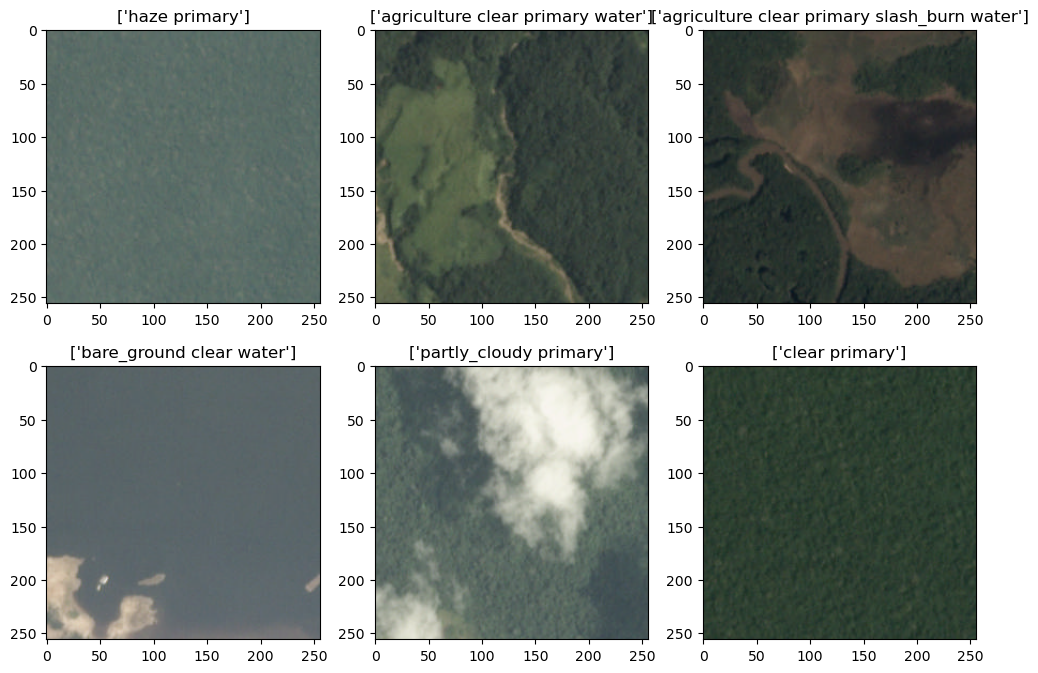

In [4]:
image_paths = sorted(glob('./images/*.jpg'))[0:1000]
image_names = list(map(lambda row: row.split("\\")[-1][:-4], image_paths))
image_names[0:10]
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(labels_df[labels_df.image_name == image_names[i]].tags.values))

Let's count all of the tags.

In [5]:
all_tags = [item for sublist in list(labels_df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/labels_df.shape[0]))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365


We'll convert them to a "one-hot" style representation where each label is a column. We can see all the labels in the table header.

In [6]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


This function returns a co-occurrence matrix showing the number of times 2 lables appear together on one image. This can help us to discover the relationship between the labels.

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
haze,2697,2670,672,0,613,129,394,202,3,0,0,2,41,5,4,5,0
primary,2670,37513,11972,27668,7001,3469,7728,4455,209,0,7175,94,683,324,332,340,98
agriculture,672,11972,12315,9150,2712,2737,6034,3377,119,0,2493,24,225,38,32,65,22
clear,0,27668,9150,28431,5502,3090,6295,3527,173,0,0,70,747,307,311,308,85
water,613,7001,2712,5502,7411,915,2125,868,24,0,1295,26,206,299,16,49,3
habitation,129,3469,2737,3090,915,3660,2786,895,41,0,441,36,163,29,4,13,3
road,394,7728,6034,6295,2125,2786,8071,1294,36,0,1382,59,323,110,10,151,2
cultivation,202,4455,3377,3527,868,895,1294,4477,126,0,748,4,89,18,35,58,8
slash_burn,3,209,119,173,24,41,36,126,209,0,33,0,10,0,2,2,2
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


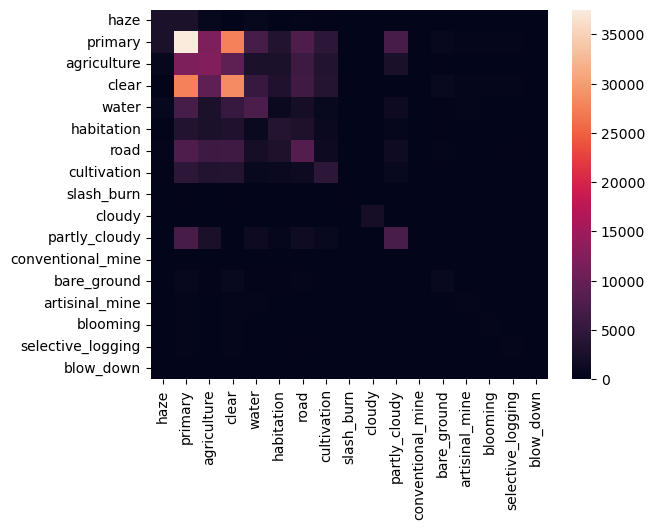

In [7]:
def make_cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix
    
# Compute the co-ocurrence matrix
make_cooccurence_matrix(label_list)

From the matrix below we can see that each image can only have exactly one weather label.

,clear,partly_cloudy,haze,cloudy
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
haze,0,0,2697,0
cloudy,0,0,0,2089


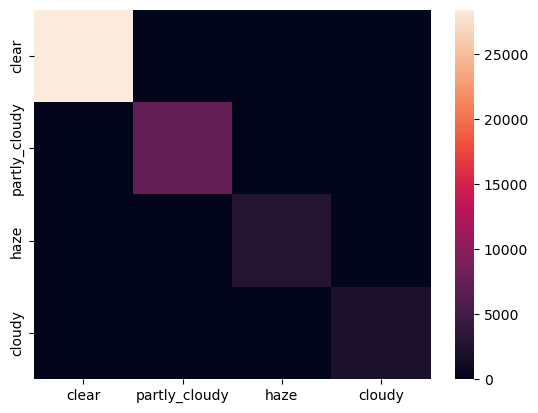

In [8]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
make_cooccurence_matrix(weather_labels)

But the land labels may overlap:

,primary,agriculture,water,cultivation,habitation
primary,37513,11972,7001,4455,3469
agriculture,11972,12315,2712,3377,2737
water,7001,2712,7411,868,915
cultivation,4455,3377,868,4477,895
habitation,3469,2737,915,895,3660


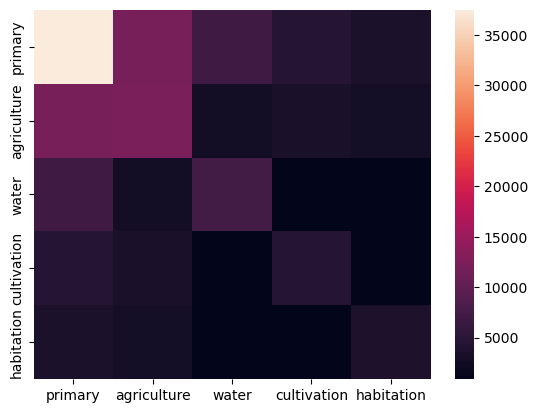

In [9]:
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation']
make_cooccurence_matrix(land_labels)

The rarer labels have very little overlap:

,slash_burn,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
slash_burn,209,0,10,0,2,2,2
conventional_mine,0,100,10,4,0,0,0
bare_ground,10,10,862,40,3,13,4
artisinal_mine,0,4,40,339,0,6,0
blooming,2,0,3,0,332,7,1
selective_logging,2,0,13,6,7,340,1
blow_down,2,0,4,0,1,1,98


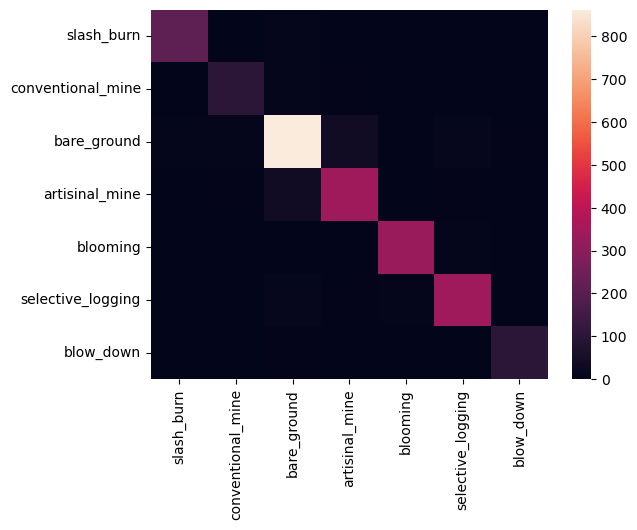

In [10]:
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
make_cooccurence_matrix(rare_labels)

#### Are there any challenges with the data? (missing values, outliers, imbalanced classes, biases, etc...) (5%)

This dataset was well prepared for a Kaggle competition, so there is no missing values. The images are labled manually, so it may contain some mis-classified images and biases. The Biggest challenge for this dataset is imbalanced classes.

Now, let's look at the labels' frequencies. We can see from the histogram that the classes are very imbalanced, e.g. the weather-related tags are much more frequent than the land-use tags, e.g. selective_logging). There is an important risk that our model barely learns the rare classes or even excludes them from the training data upon splitting between training and validating sets. We identify clearly these classes for later investigation.

<AxesSubplot:>

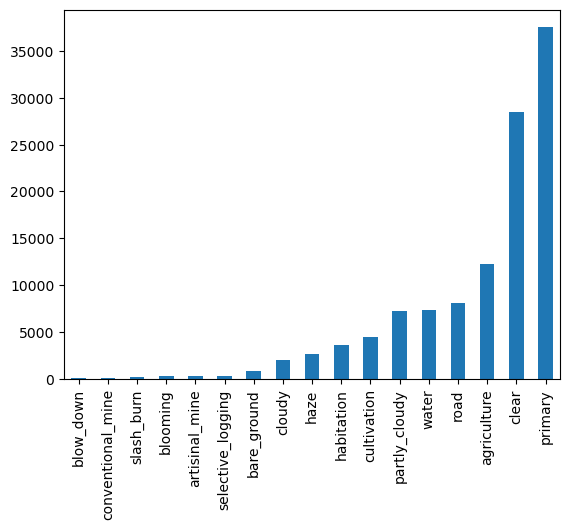

In [11]:
# Histogram of label instances
labels_df[label_list].sum().sort_values().plot.bar()

#### Does the data need any pre-processing to successfully apply standard machine learning models? If so, what kind? Please do the pre-processing that you consider necessary. (5%)

I defined the custom Dataset class to manipulate batches of data between RAM and Disk more easily. In this class, MultiLabelBinarizer() is used to convert the lables in the csv file to a "one-hot" style representation where each label is a column. Although a list of sets or tuples is a very intuitive format for multilabel data,it is unwieldy to process. This transformer converts between this intuitive format and the supported multilabel format: a (samples x classes) binary matrix indicating the presence of a class label.

In [12]:
class AmazonDataset(Dataset):
    def __init__(self, csv_path, img_path, img_ext, transform=None):
    
        tmp_df = pd.read_csv(csv_path)
        assert tmp_df['image_name'].apply(lambda x: os.path.isfile(img_path + x + img_ext)).all(), \
        "Some images referenced in the CSV file were not found"
        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        self.X_train = tmp_df['image_name']
        self.y_train = self.mlb.fit_transform(tmp_df['tags'].str.split()).astype(np.float32)

    def __getitem__(self, index):
        img = Image.open(self.img_path + self.X_train[index] + self.img_ext)
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(self.y_train[index])
        return img, label

    def __len__(self):
        return len(self.X_train.index)

#### Resize and Normalisation
For optimal performances, resnet18 needs input shape that are multiple of 32. In our case we have input of size 256. From 256, the closest multiple of 32 is 224. However, I do not have a powerful GPU. To speed up training and avoid out of memory problem, I rescaled the size of the input data to 32, which  may result in lower performance than the top benchmark models. I also normalised the dataset based on resnet pretrained mean and standard deviation intensity values. ToTensor() is useful to normalize our image values from 0-255 range to 0-1 range.

In [13]:
transformations = transforms.Compose([transforms.Resize(32), 
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ])

dataset = AmazonDataset(LABLE_PATH,IMG_PATH,IMG_EXT,transformations)

### Task and evaluation (10%)

**Guidelines**: Tell us a bit about the main task that in your view this dataset could help solve and propose and justify the evaluation criteria that would be important here, not only considering the task but your exploratory data analysis. For example, if you found that there is class imbalance in the dataset and that the most important class is the minority one, you may want to add costs in your evaluation metric to account for it, or maybe you want to use a metric specifically suited for imbalanced classification.

#### Task
The main task the dataset could help solve is to design a multilabel classifier to help detect atmospheric conditions, land cover and land use types, and ponctual human activity within the Amazon forest. It is a multi-label classification problem which means one image can be tagged with multiple lables.

#### Evaluation
One of the most commenly used evaluation metric is accuracy. The formula for accuracy is shown below:
$$Accuracy = \frac{no. of correct predictions}{no. of total predictions}$$
Since the classes in the dataset are imbalanced, I choosed the F2 score instead of the accuracy to evaluate the performance of the machine learning model. We need to firstly introduce Precision and Recall:
$$Precision = \frac{True Positive}{True Positive + False Positive}$$
$$Recall = \frac{True Positive}{True Positive + False Negative}$$
Let N be the total number of test samples. The F2 score is defined below:
$$F2 = \frac{5}{N}∑_{i=1}^{N}\frac{Precision*Recall}{4Presition+Recall}$$
Compared to the more common F1 score, the F2 penalizes false negatives more heavily than it penalizes false positives

### Design and build an ML system (20%)

**Guidelines**: Taking into account the task and evaluation criteria set in the previous section design and build now an ML system. If you go for supervised learning, you could start by partiting your dataset in train and test here and try a model on the dataset. But please justify your choices in each case. Why did you choose a specific ML model? Why is it relevant for the task and dataset at hand? Do you envision any challenges with the use of such model? 

Again, we do not ask for a specific model to be used. Instead, we will evaluate the depth and appropriatedness of your analysis. As this section (and some of the following ones) are more open ended we do not specify marks for each question.


***
Please note that if the dataset of your choice is too large to work with, you can simply choose a subset of it. We will not substract any marks for doing so. 
***


#### Split dataset into training and testing

I firstly shuffle the dataset and split it into training and testing set with a 80:20 split. Then I wrapped our custom train and test dataset within DataLoaders, with a batch size of 256 —a good trade-off between RAM usage and speed in our case.

In [14]:
# your model building code goes here
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))

if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset,
                          batch_size=256,
                          sampler=train_sampler,
                          pin_memory=True # CUDA only
                         )

test_loader = DataLoader(dataset,
                          batch_size=256,
                          sampler=test_sampler,
                          pin_memory=True # CUDA only
                         )

Then I designed the deep nural network sreucture. Convolutional Neural Networks (CNNs) performed well on image classification tasks. CNNs take images as inputs and return probabilities that the image belongs to each of the possible classes. More specifically, CNNs hierarchically extract features from images using convolutional layers, which are usually followed by pooling layers that summarise the information in the extracted feature maps. 

I used the transfer learning techniche instead of training my model on this task from scratch. The features that these models learn are often reusable for many image-related tasks. Besides, it saves a lot of computations compare to training from scratch.

I downloaded directly weights from the pretrained resnet18, and freeze all weights. I overwrite the last fully connected layer, by adding two dense layers followed by a sigmoid. This fc last part is the only layer to be trained.

In [15]:
class AmazonModel(nn.Module):
    def __init__(self):
        super(AmazonModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.num_ftrs = self.resnet.fc.in_features
        self.l1 = nn.Linear(1000 , 512)
        self.l2 = nn.Linear(512,17)
    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = F.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        return x

Then I trained my model. I explored different optimizers and hyper parameters, and finally decide to use Adam optimizer and the learning rate is set to 0.001. The binary cross entropy loss is chosen as the loss function.

In [16]:
model = AmazonModel().to(device)
torch.backends.cudnn.benchmark=True
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_train=[]
f2_score=[]
y_train_pred = np.array([])
y_train = np.array([])

def train(epoch):
    global y_train_pred
    global y_train
    batch_loss=[]
    batch_pred = np.array([])
    batch_true = np.array([])
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, target)
        output = output.cpu().detach().numpy()
        target = target.cpu().numpy()
        batch_pred = np.vstack([batch_pred, output]) if batch_pred.size else output
        batch_true= np.vstack([batch_true, target]) if batch_true.size else target
        batch_loss.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset) - split,
                100. * batch_idx / len(train_loader), loss.data.item()))
    y_train_pred=np.vstack([y_train_pred, batch_pred]) if y_train_pred.size else batch_pred
    y_train=np.vstack([y_train, batch_true]) if y_train.size else batch_true
    loss_train.append(np.mean(batch_loss))
    batch_pred = np.where(batch_pred > 0.5, 1, 0)
    f2_score.append(fbeta_score(batch_true, batch_pred, beta=2, average='samples'))

c:\Users\gzy82\.conda\envs\MV00\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gzy82\.conda\envs\MV00\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
for epoch in range(3):
    train(epoch)

Train Epoch: 0 [0/32384 (0%)]	Loss: 0.753649
Train Epoch: 0 [2560/32384 (8%)]	Loss: 0.213646
Train Epoch: 0 [5120/32384 (16%)]	Loss: 0.166334
Train Epoch: 0 [7680/32384 (24%)]	Loss: 0.151564
Train Epoch: 0 [10240/32384 (31%)]	Loss: 0.141352
Train Epoch: 0 [12800/32384 (39%)]	Loss: 0.142341
Train Epoch: 0 [15360/32384 (47%)]	Loss: 0.140768
Train Epoch: 0 [17920/32384 (55%)]	Loss: 0.133671
Train Epoch: 0 [20480/32384 (63%)]	Loss: 0.127950
Train Epoch: 0 [23040/32384 (71%)]	Loss: 0.115163
Train Epoch: 0 [25600/32384 (79%)]	Loss: 0.124061
Train Epoch: 0 [28160/32384 (87%)]	Loss: 0.115426
Train Epoch: 0 [30720/32384 (94%)]	Loss: 0.119012
Train Epoch: 1 [0/32384 (0%)]	Loss: 0.125353
Train Epoch: 1 [2560/32384 (8%)]	Loss: 0.120963
Train Epoch: 1 [5120/32384 (16%)]	Loss: 0.132735
Train Epoch: 1 [7680/32384 (24%)]	Loss: 0.112855
Train Epoch: 1 [10240/32384 (31%)]	Loss: 0.131490
Train Epoch: 1 [12800/32384 (39%)]	Loss: 0.119513
Train Epoch: 1 [15360/32384 (47%)]	Loss: 0.132292
Train Epoch: 1 [17

I plot the loss and f2 score for each epoch to see the trend of the training progress.

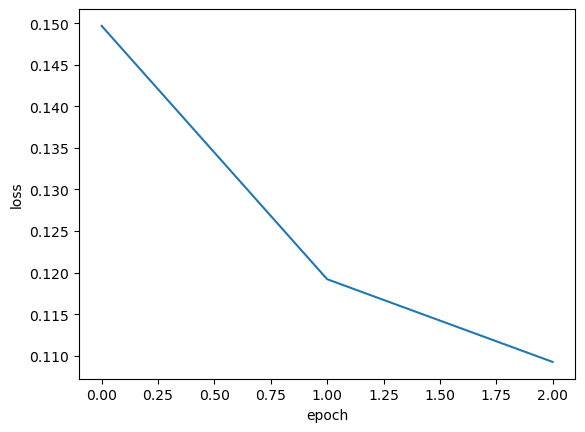

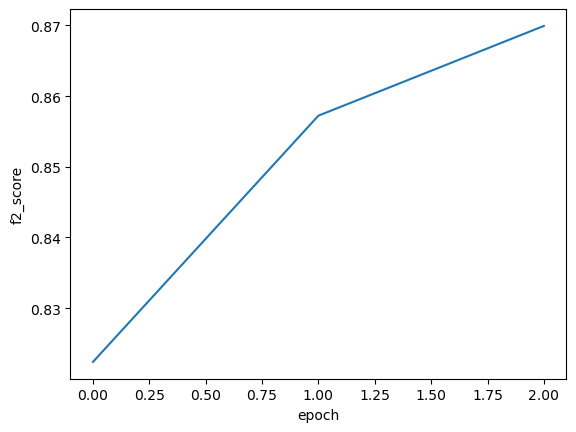

In [18]:
epoch_array=np.arange(len(loss_train))
plt.plot(epoch_array,loss_train)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(epoch_array,f2_score)
plt.ylabel('f2_score')
plt.xlabel('epoch')
plt.show()

### Experimental analysis (performance & scalability) (20%)

**Guidelines**: Test your model here. You can do hyper-parameter tuning and any ablation studies you consider important. How does your model perform? Is there any room for improvement? If so, what do you think it's needed? Comment as well on how does the model compare to previous baselines (yours or from the literature). Do you think model's performance is enough for the application that you are aiming to address? Is the model scalable to a real-world application? Is training data enough for such an application? How does the model's performance compare to a more/less computationally heavy model? Some of these questions may be more or less relevant depending on your application, so we leave it up to you to decide which factors in terms of performance and scalability you consider most important to evaluate.


#### Tune
Let's display the average of our training data prediction probability, when the truth is Y = 1 or Y = 0.

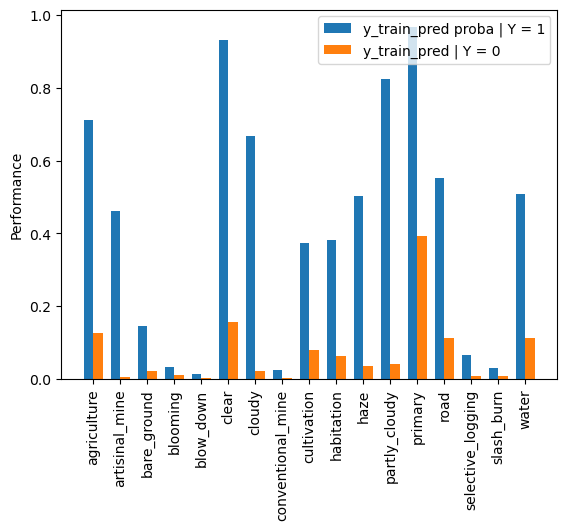

In [35]:
pos_probas, neg_probas = [], []
for idx in range(len(dataset.mlb.classes_)):
    pos_probas.append(y_train_pred[np.where(y_train[:, idx] != 0), idx].mean())
    neg_probas.append(y_train_pred[np.where(y_train[:, idx] == 0), idx].mean())

x = np.arange(len(dataset.mlb.classes_))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pos_probas, width, label="y_train_pred proba | Y = 1")
rects2 = ax.bar(x + width/2, neg_probas, width, label="y_train_pred | Y = 0")

# Add some text for labels and custom x-axis tick labels
ax.set_xticks(x, dataset.mlb.classes_)
ax.legend(loc="upper right")

# fig.tight_layout()
plt.xticks(x, dataset.mlb.classes_, rotation=90)
plt.show()

We see that default thresholding at 0.5 might not always work. So we need to define the best threshold for each individual classes.

In [36]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.5] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh= (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    Y_hat=np.where(Y_hat > best_threshs, 1, 0)
    global_best_score = fbeta_score(Y, Y_hat, beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    return best_threshs
threshs = find_best_thresholds(y_train_pred, y_train)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.2, 0.23, 0.21, 0.93, 0.89, 0.13, 0.09, 0.49, 0.21, 0.21, 0.22, 0.15, 0.25, 0.19, 0.74, 0.95, 0.21] -- best score: 0.8892067421684337


#### Test

In [39]:
y_pred = np.array([])
y_true = np.array([])
model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.binary_cross_entropy(output, target)
    output = output.cpu().detach().numpy()
    y_pred = np.vstack([y_pred, output]) if y_pred.size else output
    target = target.cpu().numpy()
    y_true= np.vstack([y_true, target]) if y_true.size else target
    if batch_idx % 10 == 0:
        print('Test:[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            batch_idx * len(data), split,
            100. * batch_idx / len(test_loader), loss.data.item()))
            
print("F2_score: "+str(fbeta_score(y_true, np.where(y_pred > threshs, 1, 0), beta=2, average='samples')))

Test:[0/8095 (0%)]	Loss: 0.123412
Test:[2560/8095 (31%)]	Loss: 0.122399
Test:[5120/8095 (62%)]	Loss: 0.119008
Test:[7680/8095 (94%)]	Loss: 0.123254
F2_score: 0.8910000757545167


My model performed well in general. It can correctly classify most of the lables. However, there are still room for improvement, especially for rare classes. I will explore this in detail in the next part. My model is not as good as the winner of the competition. The winner did more sophesticated preprocessing, and ensembled 11 different CNNs to get the best result. And I used low resolution images for training because of the limitation of the GPU performance and memory size. But I think My model is good enough for land type classification task. My model is scalable to real world application because it performed well on testing set which the model did'n see before. The training data is not enough for rare classes. The sample size for these classes are too small. The computation of my model is quite small because I applied transfer learning techinche and do not need to train from scratch. However, The performance is not as good as heavy models such as ensemble learning.

### Ethical considerations (15%)

**Guidelines**: Analyse and discuss the ethical dimensions of the application: bias, fairness, interpretability, etc. Some of these may not be relevant, but we leave this for you to decide which ones would be the relevant ones to consider for the problem at hand. Here you could do a sensitivity/interpretability analysis of the model, to study the effect of different variables or examine whether there are any biases (e.g. the model performs best for certain group of examples in your dataset). You could also link this part with your exploratory data analysis, focusing on the ethical dimensions of the dataset rather than the model you built. Justify what your analysis tell us about these ethical dimensions. 


#### Bias
The number of classses are extremely imbalanced in our dataset. Let's explore the performance of our model on each class.

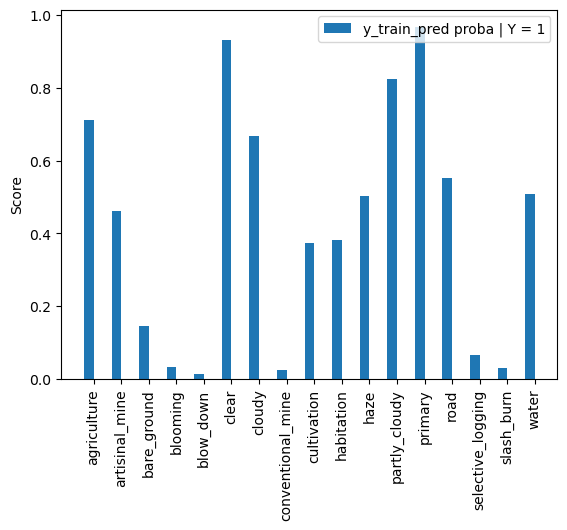

In [42]:
class_scores = {}
classes = dataset.mlb.classes_
for jdx in range(y_true.shape[1]):
    y_val = y_true[:, jdx].ravel()
    y_hat_val = (y_pred[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)

x = np.arange(len(list(class_scores.values())))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pos_probas, width, label="y_train_pred proba | Y = 1")

# Add some text for labels and custom x-axis tick labels
ax.set_ylabel('Score')
ax.set_xticks(x, list(class_scores.keys()))
ax.legend(loc="upper right")

# fig.tight_layout()
plt.xticks(x, dataset.mlb.classes_, rotation=90)
plt.show()

For weather related lables like "cloudy", "clear"..., Our model performed very well. For common land cover and land use types, such as agriculture and primary forest, we also performed quite good. But for rare land cover and land use types such as blooming, selective logging, the performance is very low. That might because the number of images with these lables are very small. We may need to get more samples to improve the performance of out model. There is room for improvement here. 

Let's observe all confusion matrices for each classes.

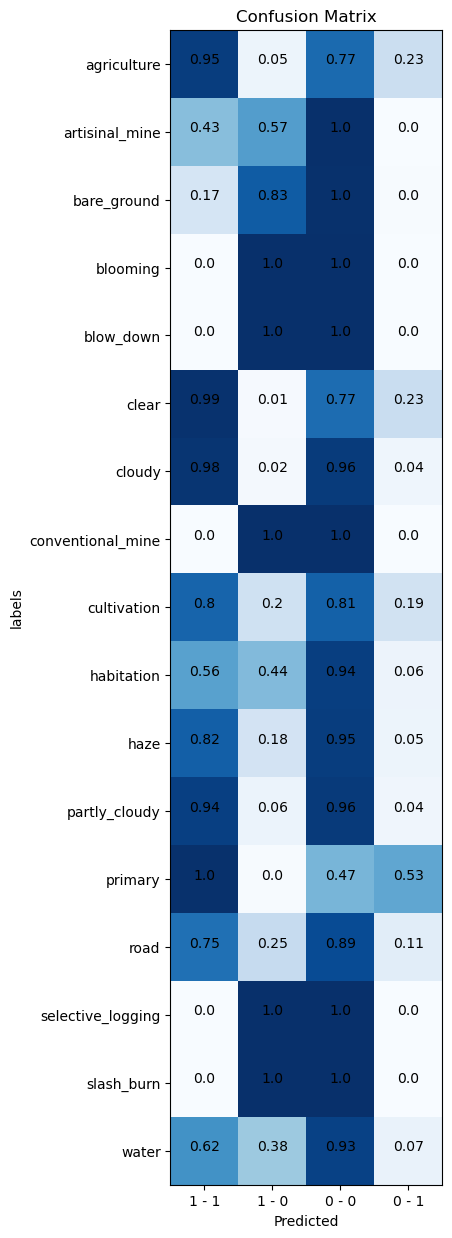

In [ ]:
import itertools

def confusion_matrix(yt, yp, classes):
    instcount = yt.shape[0]
    n_classes = classes.shape[0]
    mtx = np.zeros((n_classes, 4))
    for i in range(instcount):
        for c in range(n_classes):
            mtx[c,0] += 1 if yt[i,c]==1 and yp[i,c]==1 else 0
            mtx[c,1] += 1 if yt[i,c]==1 and yp[i,c]==0 else 0
            mtx[c,2] += 1 if yt[i,c]==0 and yp[i,c]==0 else 0
            mtx[c,3] += 1 if yt[i,c]==0 and yp[i,c]==1 else 0
    mtx = [[m0/(m0+m1), m1/(m0+m1), m2/(m2+m3), m3/(m2+m3)] for m0,m1,m2,m3 in mtx]
    plt.figure(num=None, figsize=(5, 15), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(mtx, interpolation='nearest',cmap='Blues')
    plt.title("Confusion Matrix")
    tick_marks = np.arange(n_classes)
    plt.xticks(np.arange(4), ['1 - 1','1 - 0','0 - 0','0 - 1'])
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(n_classes), range(4)):
        plt.text(j, i, round(mtx[i][j],2), horizontalalignment="center")

    #plt.tight_layout()
    plt.ylabel('labels')
    plt.xlabel('Predicted')
    plt.show()
confusion_matrix(y_true, np.where(y_pred > threshs, 1, 0), dataset.mlb.classes_)

slash_burn and blowdown scores contains more false negative (FN) than false positive (FP)
However, fbeta score is more sensitive to FP than FN by design.
Because we choose to shuffle our dataset in our dataloader, we can't display the original image of these fp and fn to visually understand our model errors. That's an issue of our implementation. So to furthering analysis, we might return filenames using our custom Dataset class.

#### Fairness
If this dataset and model is publicly available, those with better resources and technical skills may gain an unfair advantage. For example, if some government officials use the tool to identify illegal logging or mining and obtain bribes from operators, it may exacerbate the problem of corruption. Some may note that cloudy areas can mask activities such as logging, which can allow illegal activities to escape government regulation. For people who make their living from logging or mining, this model could exacerbate their economic problems.
#### Interpretability
Deep neural networks tend to have poor interpretability due to their complex network structure. This may make governments less willing to apply such models.

### Sustainable development relevance & impact (15%)

**Guidelines**: Discuss what are the current challenges surrounding this dataset in terms of sustainable development and how can ML help overcome them? Additionally, bring out all of the things you have managed to do and understand from the experiments and connect them to sustainable development. Discuss what are the challenges of deploying such a model and how it could impact our progress towards achieving the sustainable development goals. 

#### Current Challenges and How ML can help
Every minute, the world loses an area of forest the size of 48 football fields[2]. And deforestation in the Amazon Basin accounts for the largest share, leading to reduced biodiversity, habitat loss, climate change, and other devastating impacts. Effectively tracking and regulating human activities such as deforestation, road building, mining, etc. is a challenge, especially for developing countries like Brazil. Satellite imagery offers some help in such efforts, because governments no longer need to conduct costly and time-consuming field surveys. However, without the help of machine learning, the recognition of satellite imagery still needs to be done manually.

Developing machine learning systems has the potential to help governments and local stakeholders respond more quickly and effectively. The machine learning system developed in this coursework provides regulators with a scalable, low-cost, reproducible, and efficient method to classify images of tropical rainforests beyond existing datasets. The dataset and machine learning model could help other researches, such as monitoring human activity in forests in other regions of the world.
#### Challenges of deploying such a model
Firstly, The interpretability of deep neural networks are quite low. It workes like a "black box", which means it is hard to explain to non-professionals about how the model reaches to this output. This could make it harder for government officials and law enforcement officials to trust the results obtained from ML models.

In addition, the large amount of computing power required to train and test these image-based deep learning models may reduce the willingness of governments in some developing countries to use such models.
#### How it could help us achieve SDGs
In general, I believe that the machine learning model can accelerate the process of achieving SDGs. It can help the government to better monitor human activities in tropical rainforest areas and assist in decision making, thus speeding up the realisation of the following SDGs:

* SDG 12 Responsible Consumption and Production: The conservation of tropical rainforests can contribute to the sustainable development of forestry. This is because indiscriminate logging, while generating short-term benefits, may cause irreversible damage to forest resources in the long run, thereby reducing long-term benefits.
* SDG 13 Climate Action: The protection of the Amazon's primary forests helps to maintain ecological balance, absorb carbon dioxide from the atmosphere and maintain climate stability, thereby reducing the damage caused by climate change.
* SDG 15 Life on Land: Conservation of tropical rainforests can contribute to the sustainable use of terrestrial ecosystems. Machine learning models can help governments sustainably manage forests, combat desertification, halt and reverse land degradation and halt biodiversity loss.




### References

[1]https://www.kaggle.com/datasets/nikitarom/planets-dataset?datasetId=503255&sortBy=voteCount

[2]https://www.kaggle.com/competitions/planet-understanding-the-amazon-from-space/overview

[3]https://medium.com/kaggle-blog/planet-understanding-the-amazon-from-space-1st-place-winners-interview-bf66fb444bc2